In [167]:
import pandas as pd
import numpy as np
import os
import xml.etree.ElementTree as ET
from unidecode import unidecode
import matplotlib.pyplot as plt
from re import finditer
from pprint import pprint
from time import time
import pickle
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_curve

In [6]:
def load_PAN_XML_tweets(file_dir):
    files_e = os.listdir(file_dir)
    users = []
    for fil_e in files_e:
        if fil_e[-3:] == 'xml':
            tree = ET.parse(file_dir+'/'+fil_e)
            root = tree.getroot()
            users.append([fil_e[:-3], []])
            for CDATA in root.findall('document'):
                users[-1][1].append(CDATA.text[:-2])
    return users

In [7]:
users = load_PAN_XML_tweets('data/pan15-english')

In [8]:
ydf = pd.read_csv('data/pan15-english/truth.txt', sep=':::', header=None, names=['userid', 'gender', 'age_group', 'extroverted', 'stable', 'agreeable', 'conscientious', 'open'])

/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [9]:
ydf['userid'] = ydf['userid'].map(lambda x: x[:8])

In [10]:
def camel_case_split(word):
    matches = finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', word)
    return [m.group(0) for m in matches]

In [11]:
def featurize_tweet(tweet):
    tokens = unidecode(tweet).split()
    RT = 0
    link_ct = 0
    at_ct = 0
    hashtags = []
    tag_ct = 0
    music_share = 0
    excl_ct = 0
    ques_ct = 0
    ellipsis = 0
    I_my = 0
    We_our = 0
    you_your = 0
    loud_words = 0
    prop_names = 0
    CAP_ct = 0
    rem_tok = []
    add_tok = []
    for token in tokens:
        http_loc = token.find('http')
        if token[:2] == 'RT':
            RT += 1
            rem_tok.append(token)
        elif token[0] == '@' or (len(token) > 1 and token[1] == '@'):
            at_ct += 1
            rem_tok.append(token)
        elif http_loc != -1:
            link_ct += 1
            rem_tok.append(token)
            if http_loc != 0:
                token = token[:http_loc]
                add_tok.append(token)
        if token in {'#NowPlaying', '(Courtesy', '(Feat.', '#Shazam'}:
            music_share += 1
        if token[0] == '#' and len(token) > 1:
            if not token[1:].isdigit():
                tag_ct += 1
                hashtags.append(token)
                rem_tok.append(token)
                add_tok.extend([token[1:]])
                if camel_case_split(token[1:])[0] != token[1:]:
                    add_tok.extend(camel_case_split(token[1:]))
        elif token.lower() in {'i', "i'm", "i've", "i'd", "i'll", 'me', 'my', 'mine', 'myself'}:
            I_my += 1
        elif token.lower() in {'we', 'our', 'us', "we'd", "we've", "we'll", 'ours', 'ourselves'}:
            We_our +=1
        elif token.lower() in {'you', 'your', "you've", "you'd", "you'll", 'yours', 'yourself'}:
            you_your += 1
        if token.isupper():
            loud_words += 1
        elif token[0].isupper():
            prop_names += 1
        for c in token:
            if c == '!':
                excl_ct += 1
            if c == '?':
                ques_ct += 1
            if c == '.':
                ellipsis += 1
    for token in add_tok:
        tokens.append(token)
    for token in rem_tok:
        tokens.remove(token)
    for token in tokens:
        for c in token:
            if c.isupper():
                CAP_ct += 1
    word_ct = len(tokens)
    tw_text = ' '.join(tokens)
    features = [tweet, 1, RT, word_ct, link_ct, at_ct, hashtags, tag_ct, music_share, excl_ct, ques_ct, ellipsis, I_my, We_our, you_your, loud_words, prop_names, CAP_ct, tw_text]
    columns = ['tweet', 'tweet_ct', 'RT', 'word_ct', 'link_ct', 'at_ct', 'hashtags', 'tag_ct', 'music_share', 'excl_ct', 'ques_ct', 'ellipsis', 'I_my', 'We_our', 'you_your', 'loud_words', 'prop_names', 'CAP_ct', 'tw_text']
    return features, columns

In [12]:
df = pd.DataFrame(columns=['user']+featurize_tweet(users[0][1][0])[1])
for user in users:
    for tweet in user[1]:
        features, cols = featurize_tweet(tweet)
        df = df.append(pd.DataFrame([[user[0][:8]]+features], columns=['user']+cols))

/home/ec2-user/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:46: RuntimeWarning: Argument <type 'str'> is not an unicode object. Passing an encoded string will likely have unexpected results.
  _warn_if_not_unicode(string)


In [13]:
keep_cols = list(df.columns)
keep_cols.remove('tweet')
keep_cols.remove('hashtags')
keep_cols.remove('tw_text')
compdf = df[keep_cols].groupby('user').sum()

In [14]:
compdf2 = compdf.apply(lambda x: 100.0*x/x['tweet_ct'], axis=1)

In [15]:
compdf2['tw_text'] = df[['user', 'tw_text']].groupby('user').agg(lambda x: ' '.join(x))

In [16]:
ydf_ind = ydf.set_index('userid')

In [17]:
combineddf = compdf2.join(ydf_ind, how='outer')

In [18]:
X = combineddf[list(compdf2.columns)]
y = combineddf[list(ydf_ind.columns)]

In [19]:
gender_dict = {'M': -1.0, 'F': 1.0}
y = y.replace(gender_dict)

In [20]:
age_dict = {'18-24': 1.0, '25-34': 2.0, '35-49': 3.0, '50-XX': 4.0}
y = y.replace(age_dict)

In [28]:
X['tw_text'][:10]

02ae95de    Things I want for my business cards but are to...
03f72f70    "If you fight for a cause then fight for a cau...
0aa7bace    that tweet was mainly for you ;-) cheers! I am...
0b66092a    'red' and 'blue' and then you wait to see what...
1094e809    I sit with a boy in english he became my frien...
11c285a3    not sure if there are notes for this particula...
150bfac9    #313 - Turns suns. (Courtesy of A. Castelletti...
1661bc1b    TIPICO, EMPIEZAS TRABAJOS DE IMPERMEABILIZACIO...
16b423e5    ? In A Different Place - Ride NowPlaying Now P...
17591594    Getting up at 5! a rare case for me. and that ...
Name: tw_text, dtype: object

In [21]:
def LSA_pipe(Xtrain, ytrains, lsa_n):
    pl = []
    vect = []
    tfidf = []
    lsa = []
    rfr = []
    for yt in ytrains:
        vect.append(CountVectorizer())
        tfidf.append(TfidfTransformer())
        lsa.append(TruncatedSVD())
        rfr.append(RandomForestRegressor())
        pl.append(Pipeline([
            ('vect', vect[-1]),
            ('tfidf', tfidf[-1]),
            ('lsa', lsa[-1]),
            ('rfr', rfr[-1]),
            ]))
        pl[-1].set_params(rfr__max_depth= 6,
            rfr__n_estimators= 100,
            lsa__n_components= lsa_n,
            tfidf__norm= 'l1',
            tfidf__use_idf= False,
            vect__max_df= 1.0,
            vect__max_features= 5000,
            vect__ngram_range= (1, 3),
            vect__stop_words= None).fit(Xtrain, yt)

    return pl, vect, tfidf, lsa, rfr

In [56]:
rfr_lsa[1].n_outputs_

1

In [29]:
pl_lsa, vect, tfidf, lsa, rfr_lsa = LSA_pipe(X['tw_text'], y.values.T, 50)

In [30]:
lance = pickle.load( open('data/lance.pkl') )

In [116]:
lance.reverse()

TypeError: 'NoneType' object has no attribute '__getitem__'

In [117]:
lance[:10]

[u'@sturoberts1 good luck',
 u"@jimrosing I'll be out for an easy spin at some point. Not sure when tho doc. GL in the race",
 u"@Fudgelynda Saturday here in Hawai'i.",
 u'I hope both @bradsherman &amp; @RepHowardBerman can agree that #YESON29 is the right vote! cc: @prop29 #savelives',
 u"Thanks @chrislieto for the swim this am. Main set - 6x50's on 40 followed by a 300 at 85%. 3 times thru.",
 u"@ElizBerkley @gdlauren it's in Colorado. Will send when I get there.",
 u"RT @jayprasuhn: Some new @DonaldMiralle outtakes from our @LavaMagazine shoot with @LanceArmstrong -check out Don's blog here. http://t. ...",
 u"Just taped a segment w/ @billmaher who's filling in for @piersmorgan. Talking @Prop29 and @IronmanTri. #yeson29!",
 u'Damn, the #Spurs are on fire.',
 u'@bowmar88 @lancearmstrong thanks!']

In [74]:
def pers_pred_seq(tweet_list, step, vect, tfidf, lsa, rfr):
    '''
    INPUT: list of strings, int, list of pipelines, list of vectorizors, list of tfidf tranformers
            list of lsa transformers, list of random forest regressors, 7 in each list.
    OUTPUT: list of values suitable for plotting plus results from all decision tree estimators in
            the forest with their standard deviation for increasing numbers of tweets.
    '''
    l_results = []
    l_pred_std = []
#    l_tpreds = []
    df = pd.DataFrame(columns=featurize_tweet(tweet_list[0])[1])
    for i in range(1+len(tweet_list)/step):
        add_tweets = tweet_list[step*i:step*(i+1)]
        for tweet in add_tweets:
            features, cols = featurize_tweet(tweet)
            df = df.append(pd.DataFrame([features], columns=cols))
        keep_cols = list(df.columns)
        keep_cols.remove('tweet')
        keep_cols.remove('hashtags')
        keep_cols.remove('tw_text')
        compdf = df[keep_cols].sum()
        compdf['tw_text'] = ' '.join(df['tw_text'].tolist())
        tpreds = [[] for k in range(7)]
        pred_std = []
        y_pred_l = []
        for j in range(7):
            X = lsa[j].transform(tfidf[j].transform(vect[j].transform(pd.Series([compdf['tw_text']]))))
            y_pred_l.append(rfr[j].predict(X))
            for tree in rfr[j].estimators_:
                tpreds[j].append(tree.predict(X))
            pred_std.append(np.array(tpreds[j]).std())
        l_results.append(y_pred_l[:])
        l_pred_std.append(pred_std[:])
#        l_tpreds.append(tpreds)
    return l_results, l_pred_std #, l_tpreds

In [62]:
df = pd.DataFrame(columns=featurize_tweet(lance[0])[1])

In [64]:
add_tweets = lance[0:50]

In [65]:
for tweet in add_tweets:
    features, cols = featurize_tweet(tweet)
    df = df.append(pd.DataFrame([features], columns=cols))

In [66]:
keep_cols = list(df.columns)
keep_cols.remove('tweet')
keep_cols.remove('hashtags')
keep_cols.remove('tw_text')
compdf = df[keep_cols].sum()
compdf['tw_text'] = ' '.join(df['tw_text'].tolist())

In [71]:
pd.Series([compdf['tw_text']])

0    Floyd? July 2 in - cold and wet! None the less...
dtype: object

In [118]:
plot_data = pers_pred_seq(lance, 50, vect, tfidf, lsa, rfr_lsa)

In [108]:
np.array(plot_data[1]).T[0]

array([ 0.95664922,  0.97271709,  0.96959509,  0.97508577,  0.96052976,
        0.9618307 ,  0.97314994,  0.97606055,  0.94563492,  0.95504652,
        0.92656812,  0.93301089,  0.90590738,  0.93549369,  0.94148918,
        0.94148918,  0.95249786,  0.95249786,  0.95249786,  0.95249786,
        0.94740632,  0.94186267,  0.94740632,  0.94740632,  0.94186267,
        0.92454188,  0.92454188,  0.93147471,  0.93147471,  0.93585889,
        0.93585889,  0.93147471,  0.91712062,  0.93147471,  0.92454188,
        0.94740632,  0.94740632,  0.95249786,  0.95249786,  0.95249786,
        0.94740632,  0.94740632,  0.94740632,  0.94186267,  0.93585889,
        0.95249786,  0.95249786,  0.94740632,  0.94740632,  0.94740632,
        0.94740632,  0.94186267,  0.94186267,  0.94186267,  0.94186267,
        0.93585889,  0.92993106,  0.94186267,  0.94186267,  0.94186267,
        0.93639176,  0.93585889,  0.93585889,  0.94186267])

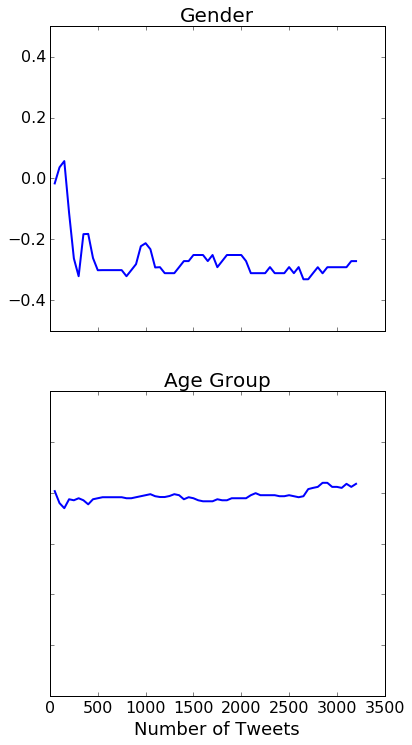

In [145]:
x = linspace(50, 3200, 64)
y = np.array(plot_data[0]).T[0]
f, axarr = plt.subplots(2, sharex=True)
f.set_figheight(12)
f.set_figwidth(6)
axarr[0].set_ylim([-.5,.5])
axarr[0].plot(x, y[0], linewidth=2)
axarr[0].set_title('Gender', fontsize=20)
axarr[0].tick_params(axis='both', which='major', labelsize=16)
axarr[1].set_ylim([1,4])
axarr[1].plot(x, y[1], linewidth=2)
axarr[1].set_title('Age Group', fontsize=20)
axarr[1].tick_params(axis='y', which='both', labelleft='off', labelright='off')
axarr[1].tick_params(axis='x', which='major', labelsize=16)
plt.xlabel('Number of Tweets', fontsize=18)
f.savefig('ga.jpg')
plt.show()

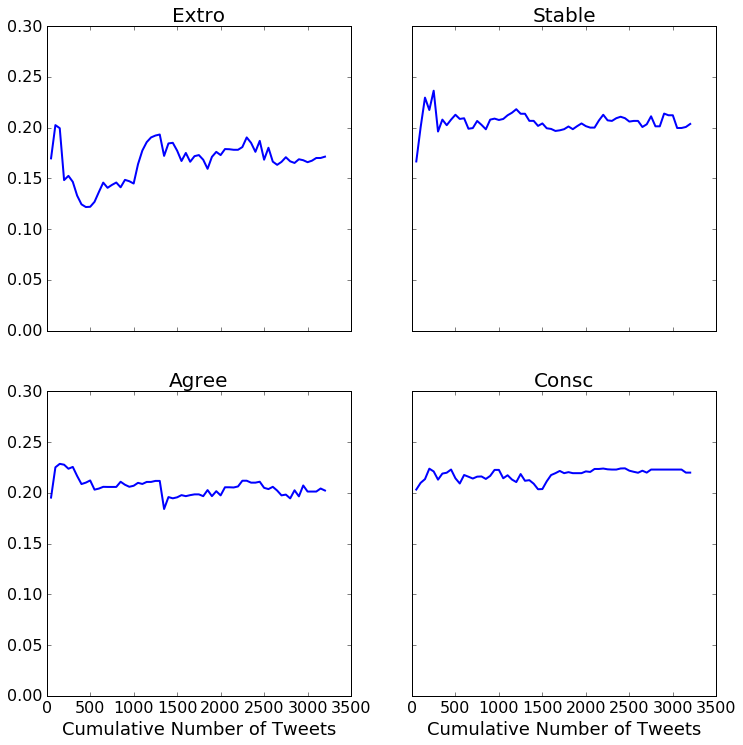

In [166]:
x = linspace(50, 3200, 64)
y = np.array(plot_data[0]).T[0]
f, axarr = plt.subplots(2, 2, sharey='all', sharex='all')
f.set_figheight(12)
f.set_figwidth(12)
axarr[0][0].set_ylim([0,.3])
axarr[0][0].plot(x, y[2], linewidth=2)
axarr[0][0].set_title('Extro', fontsize=20)
axarr[0][0].tick_params(axis='both', which='major', labelsize=16)
axarr[0][1].plot(x, y[3], linewidth=2)
axarr[0][1].set_title('Stable', fontsize=20)
axarr[0][1].tick_params(axis='x', which='major', labelsize=16)
axarr[1][0].set_ylim([0,.3])
axarr[1][0].plot(x, y[4], linewidth=2)
axarr[1][0].set_title('Agree', fontsize=20)
axarr[1][0].tick_params(axis='both', which='major', labelsize=16)
axarr[1][0].set_xlabel('Cumulative Number of Tweets', fontsize=18)
axarr[1][1].plot(x, y[5], linewidth=2)
axarr[1][1].set_title('Consc', fontsize=20)
axarr[1][1].tick_params(axis='x', which='major', labelsize=16)
axarr[1][1].set_xlabel('Cumulative Number of Tweets', fontsize=18)
f.savefig('esac.jpg')
plt.show()

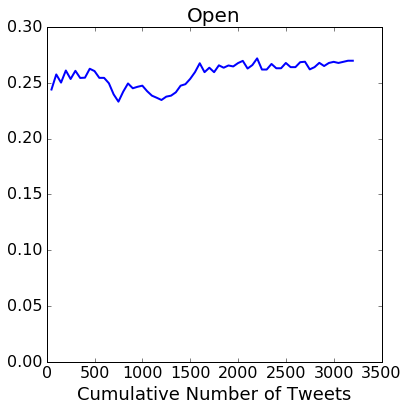

In [165]:
x = linspace(50, 3200, 64)
y = np.array(plot_data[0]).T[0]
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(6)
ax.set_ylim([0,.3])
ax.plot(x, y[6], linewidth=2)
ax.set_title('Open', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Cumulative Number of Tweets', fontsize=18)
f.savefig('o.jpg')
plt.show()

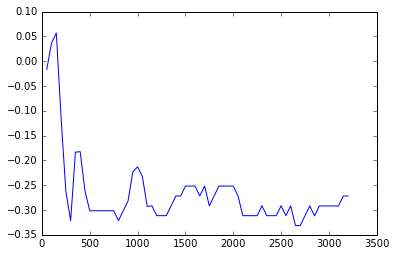

In [126]:
x = linspace(50, 3200, 64)
y = np.array(plot_data[0]).T[0][0]
plt.plot(x, y)
plt.show()

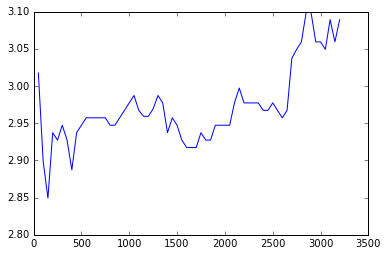

In [128]:
x = linspace(50, 3200, 64)
y = np.array(plot_data[0]).T[0]
plt.plot(x, y[1])
plt.show()

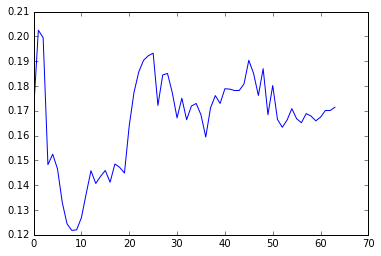

In [121]:
plt.plot(np.array(plot_data[0]).T[0][2])
plt.show()

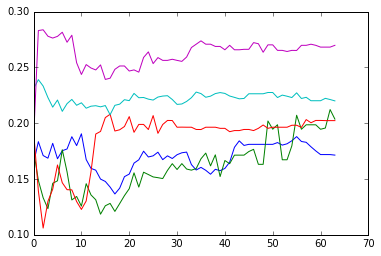

In [99]:
plt.plot(np.array(plot_data[0]).T[0][2])
plt.plot(np.array(plot_data[0]).T[0][3])
plt.plot(np.array(plot_data[0]).T[0][4])
plt.plot(np.array(plot_data[0]).T[0][5])
plt.plot(np.array(plot_data[0]).T[0][6])
plt.show()

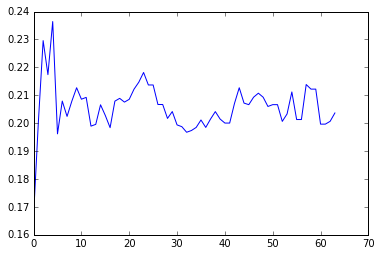

In [122]:
plt.plot(np.array(plot_data[0]).T[0][3])

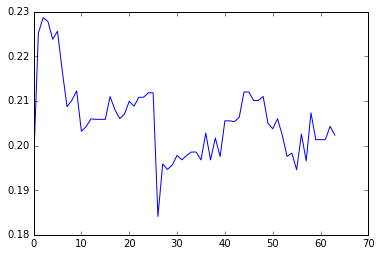

In [123]:
plt.plot(np.array(plot_data[0]).T[0][4])

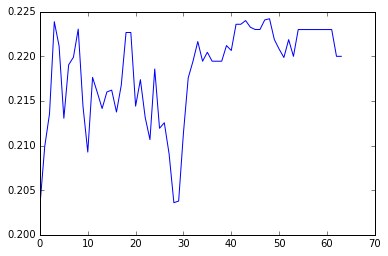

In [124]:
plt.plot(np.array(plot_data[0]).T[0][5])

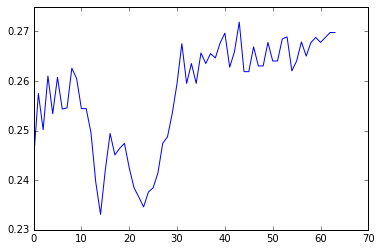

In [125]:
plt.plot(np.array(plot_data[0]).T[0][6])

In [169]:
homer = pickle.load( open('data/homer.pkl') )
donald = pickle.load( open('data/donald.pkl') )

In [170]:
homer.reverse()
donald.reverse()

In [173]:
len(homer)

1640

In [171]:
homer_plot_data = pers_pred_seq(homer, 50, vect, tfidf, lsa, rfr_lsa)

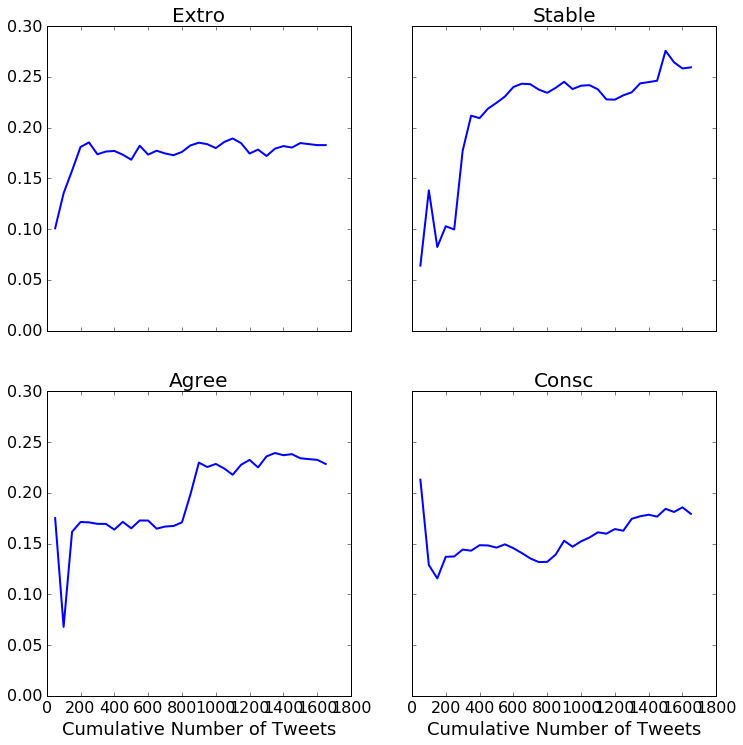

In [174]:
x = linspace(50, 1650, 33)
y = np.array(homer_plot_data[0]).T[0]
f, axarr = plt.subplots(2, 2, sharey='all', sharex='all')
f.set_figheight(12)
f.set_figwidth(12)
axarr[0][0].set_ylim([0,.3])
axarr[0][0].plot(x, y[2], linewidth=2)
axarr[0][0].set_title('Extro', fontsize=20)
axarr[0][0].tick_params(axis='both', which='major', labelsize=16)
axarr[0][1].plot(x, y[3], linewidth=2)
axarr[0][1].set_title('Stable', fontsize=20)
axarr[0][1].tick_params(axis='x', which='major', labelsize=16)
axarr[1][0].set_ylim([0,.3])
axarr[1][0].plot(x, y[4], linewidth=2)
axarr[1][0].set_title('Agree', fontsize=20)
axarr[1][0].tick_params(axis='both', which='major', labelsize=16)
axarr[1][0].set_xlabel('Cumulative Number of Tweets', fontsize=18)
axarr[1][1].plot(x, y[5], linewidth=2)
axarr[1][1].set_title('Consc', fontsize=20)
axarr[1][1].tick_params(axis='x', which='major', labelsize=16)
axarr[1][1].set_xlabel('Cumulative Number of Tweets', fontsize=18)
plt.show()

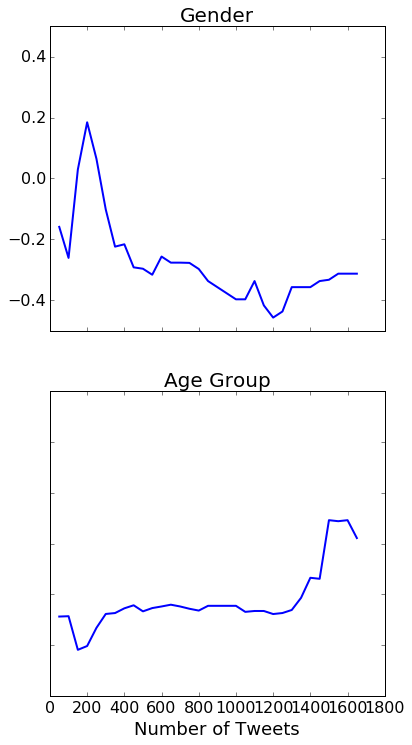

In [175]:
x = linspace(50, 1650, 33)
y = np.array(homer_plot_data[0]).T[0]
f, axarr = plt.subplots(2, sharex=True)
f.set_figheight(12)
f.set_figwidth(6)
axarr[0].set_ylim([-.5,.5])
axarr[0].plot(x, y[0], linewidth=2)
axarr[0].set_title('Gender', fontsize=20)
axarr[0].tick_params(axis='both', which='major', labelsize=16)
axarr[1].set_ylim([1,4])
axarr[1].plot(x, y[1], linewidth=2)
axarr[1].set_title('Age Group', fontsize=20)
axarr[1].tick_params(axis='y', which='both', labelleft='off', labelright='off')
axarr[1].tick_params(axis='x', which='major', labelsize=16)
plt.xlabel('Number of Tweets', fontsize=18)
plt.show()

In [183]:
donald_plot_data = pers_pred_seq(donald, 50, vect, tfidf, lsa, rfr_lsa)

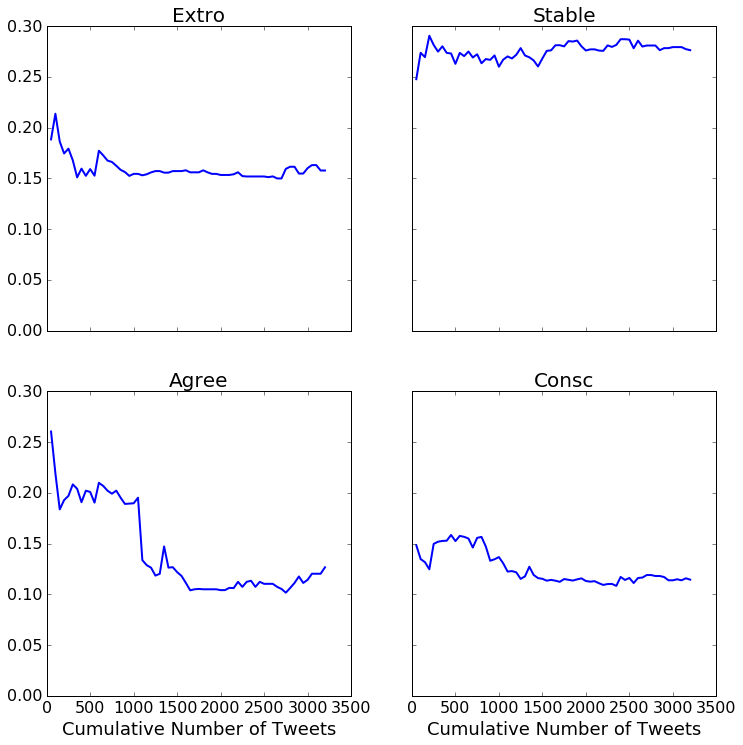

In [184]:
x = linspace(50, 3200, 64)
y = np.array(donald_plot_data[0]).T[0]
f, axarr = plt.subplots(2, 2, sharey='all', sharex='all')
f.set_figheight(12)
f.set_figwidth(12)
axarr[0][0].set_ylim([0,.3])
axarr[0][0].plot(x, y[2], linewidth=2)
axarr[0][0].set_title('Extro', fontsize=20)
axarr[0][0].tick_params(axis='both', which='major', labelsize=16)
axarr[0][1].plot(x, y[3], linewidth=2)
axarr[0][1].set_title('Stable', fontsize=20)
axarr[0][1].tick_params(axis='x', which='major', labelsize=16)
axarr[1][0].set_ylim([0,.3])
axarr[1][0].plot(x, y[4], linewidth=2)
axarr[1][0].set_title('Agree', fontsize=20)
axarr[1][0].tick_params(axis='both', which='major', labelsize=16)
axarr[1][0].set_xlabel('Cumulative Number of Tweets', fontsize=18)
axarr[1][1].plot(x, y[5], linewidth=2)
axarr[1][1].set_title('Consc', fontsize=20)
axarr[1][1].tick_params(axis='x', which='major', labelsize=16)
axarr[1][1].set_xlabel('Cumulative Number of Tweets', fontsize=18)
plt.show()

In [181]:
donald.reverse()

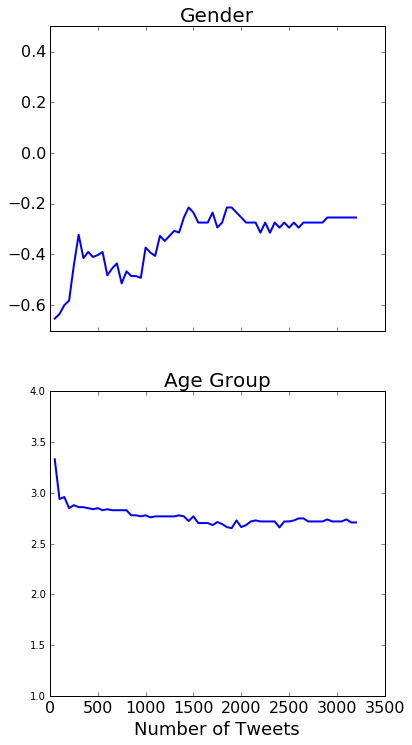

In [187]:
x = linspace(50, 3200, 64)
y = np.array(donald_plot_data[0]).T[0]
f, axarr = plt.subplots(2, sharex=True)
f.set_figheight(12)
f.set_figwidth(6)
axarr[0].set_ylim([-.7,.5])
axarr[0].plot(x, y[0], linewidth=2)
axarr[0].set_title('Gender', fontsize=20)
axarr[0].tick_params(axis='both', which='major', labelsize=16)
axarr[1].set_ylim([1,4])
axarr[1].plot(x, y[1], linewidth=2)
axarr[1].set_title('Age Group', fontsize=20)
axarr[1].tick_params(axis='x', which='major', labelsize=16)
plt.xlabel('Number of Tweets', fontsize=18)
plt.show()